- System 07 from the VADER dataset
- All available data (>3yrs)

In [1]:
from sys import path
path.append('..')
from clearsky.main import IterativeClearSky
from clearsky.utilities import make_time_series
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}
from datetime import datetime

In [2]:
pv_data = pd.read_pickle('/Users/bennetmeyers/Documents/CS229/Project/SolarForecasting/data/master_dataset.pkl')

In [3]:
df = pv_data['total_power'].fillna(0)

In [4]:
df.head()

2015-07-14 16:00:00    134.88710
2015-07-14 16:05:00    128.21800
2015-07-14 16:10:00    122.19490
2015-07-14 16:15:00    116.57555
2015-07-14 16:20:00    109.86805
Freq: 5T, Name: total_power, dtype: float64

In [5]:
days = df.resample('D').max().index[1:-1]
start = days[0]
end = days[-1]
print start, end

2015-07-15 00:00:00 2017-07-14 00:00:00


In [6]:
end - start

Timedelta('730 days 00:00:00')

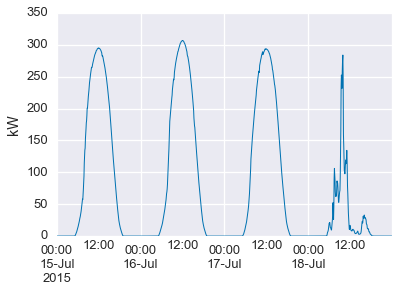

In [7]:
pa = PLOT_ARGS
pa['figsize'] = (6,4)
df.loc[start.strftime('%m/%d/%y'):(start + 3).strftime('%m/%d/%y')].plot(legend=False, **pa)
plt.ylabel('kW')

In [8]:
D = df.loc[start:end].iloc[:-1].as_matrix().reshape(288, -1, order='F')
p = df.loc[start:end]

In [9]:
U, Sig, Vt = np.linalg.svd(D, full_matrices=False)
U[:, 0] *= -1
Vt[0] *= -1

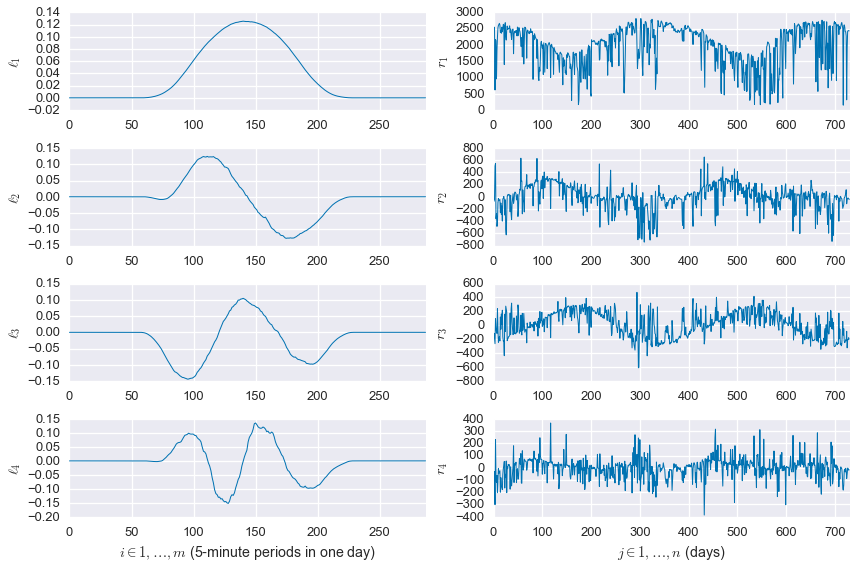

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,8))
for i in xrange(4):
    ax[i][0].plot(U.T[i], linewidth=1)
    ax[i][0].set_xlim(0, 287)
    ax[i][0].set_ylabel('$\\ell_{}$'.format(i+1))
    ax[i][1].plot((np.diag(Sig).dot(Vt))[i], linewidth=1)
    ax[i][1].set_xlim(0, D.shape[1])
    ax[i][1].set_ylabel('$r_{}$'.format(i+1))
ax[-1][0].set_xlabel('$i \\in 1, \\ldots, m$ (5-minute periods in one day)')
ax[-1][1].set_xlabel('$j \\in 1, \\ldots, n$ (days)')
plt.tight_layout()
plt.show()

In [11]:
ics = IterativeClearSky(D, k=5)

In [12]:
ics.mu_L = 5e3
ics.mu_R = 1e3
ics.tau = 0.9
ics.minimize_objective(max_iter=8)

starting at 27225763.446 [88822.48788044025, 619.9226447621827, 27136321.035102036, 0]
iteration 1: 81282.203 [73835.236   109.918  7337.049     0.   ]
iteration 2: 67736.687 [60450.527   146.237  7139.923     0.   ]
iteration 3: 67073.086 [59722.991   169.386  7180.709     0.   ]
iteration 4: 66975.870 [59610.664   174.722  7190.484     0.   ]
iteration 5: 66927.531 [59565.492   179.802  7182.237     0.   ]
Minimization complete in 1.96 minutes


In [13]:
ics.beta.value

0.023440879255790924

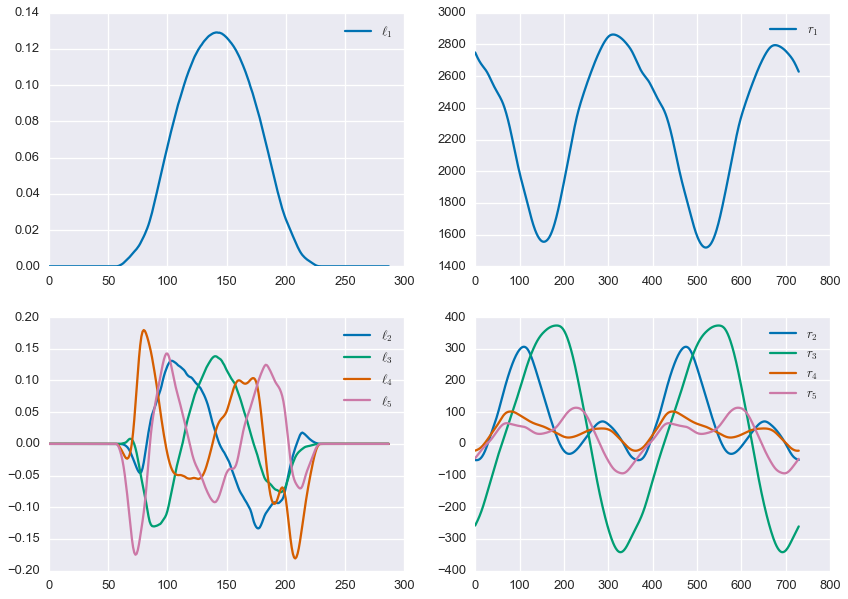

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax[0, 1].plot(ics.R_cs.value[0].T)
ax[1, 1].plot(ics.R_cs.value[1:].T)
ax[0, 0].plot(ics.L_cs.value[:, 0])
ax[1, 0].plot(ics.L_cs.value[:, 1:])
ax[0, 0].legend(['$\\ell_1$'])
ax[1, 0].legend(['$\\ell_{}$'.format(ix) for ix in range(2, ics.R_cs.value.shape[0]+1)])
ax[0, 1].legend(['$r_{1}$'])
ax[1, 1].legend(['$r_{}$'.format(ix) for ix in range(2, ics.R_cs.value.shape[0]+1)])
plt.show()

(0, 0.05)

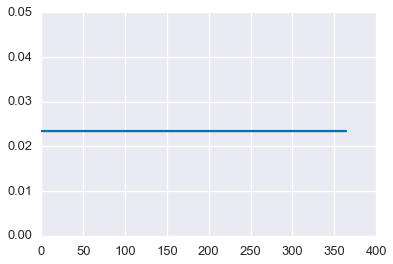

In [15]:
plt.plot((ics.R_cs.value[0,:-365].A1 - ics.R_cs.value[0,365:].A1) / ics.R_cs.value[0,:-365].A1)
plt.ylim(0, 0.05)

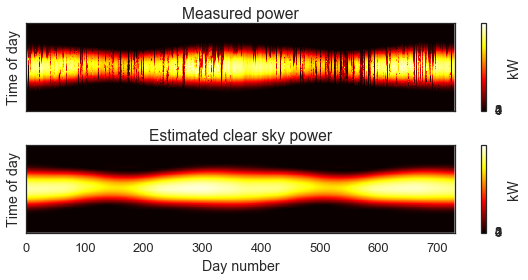

In [16]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(8,4), sharex=True)
    foo = ax[0].imshow(ics.D, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(ics.L_cs.value.dot(ics.R_cs.value), cmap='hot',
                       vmin=0, vmax=np.max(ics.D), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0], label='kW', ticks=range(5))
    plt.colorbar(bar, ax=ax[1], label='kW', ticks=range(5))
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

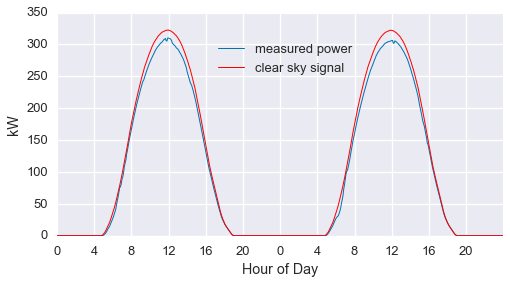

In [17]:
D1 = 350
D2 = D1 + 2
actual = p[D1*288:D2*288].as_matrix()
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F').A1
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='measured power')
ax.plot(clearsky, linewidth=1, color='red', label='clear sky signal')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 288*(D2-D1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 288*2, 2*24))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
plt.show()

In [18]:
print sum(ics.L_cs.size) + sum(ics.R_cs.size)

1028


(0, 1440)

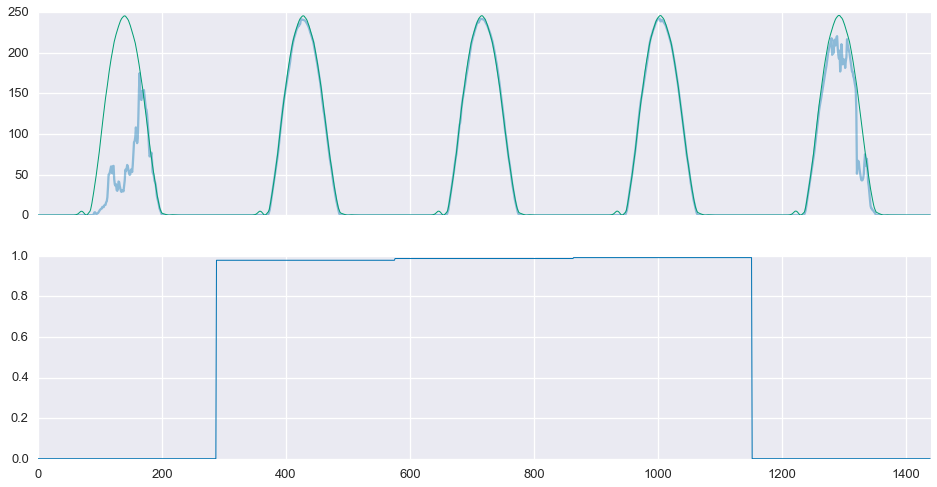

In [19]:
D1 = 520
D2 = D1+5
actual = p[D1*288:D2*288].as_matrix()
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F').A1
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(ics.weights[D1:D2], 288), linewidth=1)
ax[1].set_xlim(0, 288*(D2-D1))